## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-07-30 11:25:49.714 | INFO     |  Running on cpu


In [3]:
#task = 'LiftBlock-v0'
task = 'OpenDrawer'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2025-07-30 11:25:53.069 | INFO     |  Loading dataset(s): 
2025-07-30 11:25:53.069 | INFO     |    Initializing datasete using /home/iter/work/dl-lab/TAPAS/data/OpenDrawer/demos/metadata.json
2025-07-30 11:25:53.070 | INFO     |    Extracted gt object labels [81, 83, 88, 93]
2025-07-30 11:25:53.071 | INFO     |    Extracted tsdf object labels []
2025-07-30 11:25:53.071 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config, indeces=[0, 2, 3, 4])

n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)

2025-07-30 11:25:59.879 | INFO     |  Subsampling to length 103 using strategy mean-length.


In [6]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=1,

    trans_cov_mask_t_pos_corr = False,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=1e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.49,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=5,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)



In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-07-30 11:26:00.031 | INFO     |  Fitting AutoTPGMM
2025-07-30 11:26:00.031 | INFO     |  Performing fitting actions: [INIT]
2025-07-30 11:26:00.031 | INFO     |  Segmenting trajectories


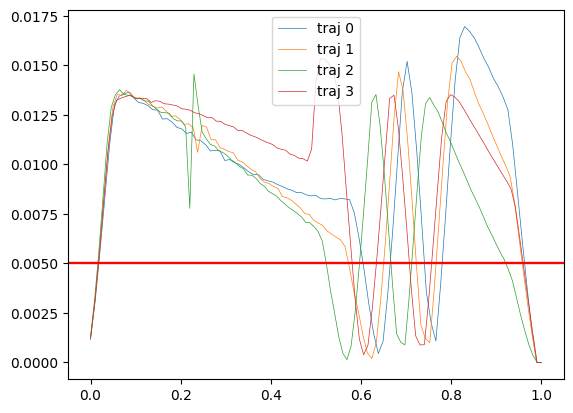

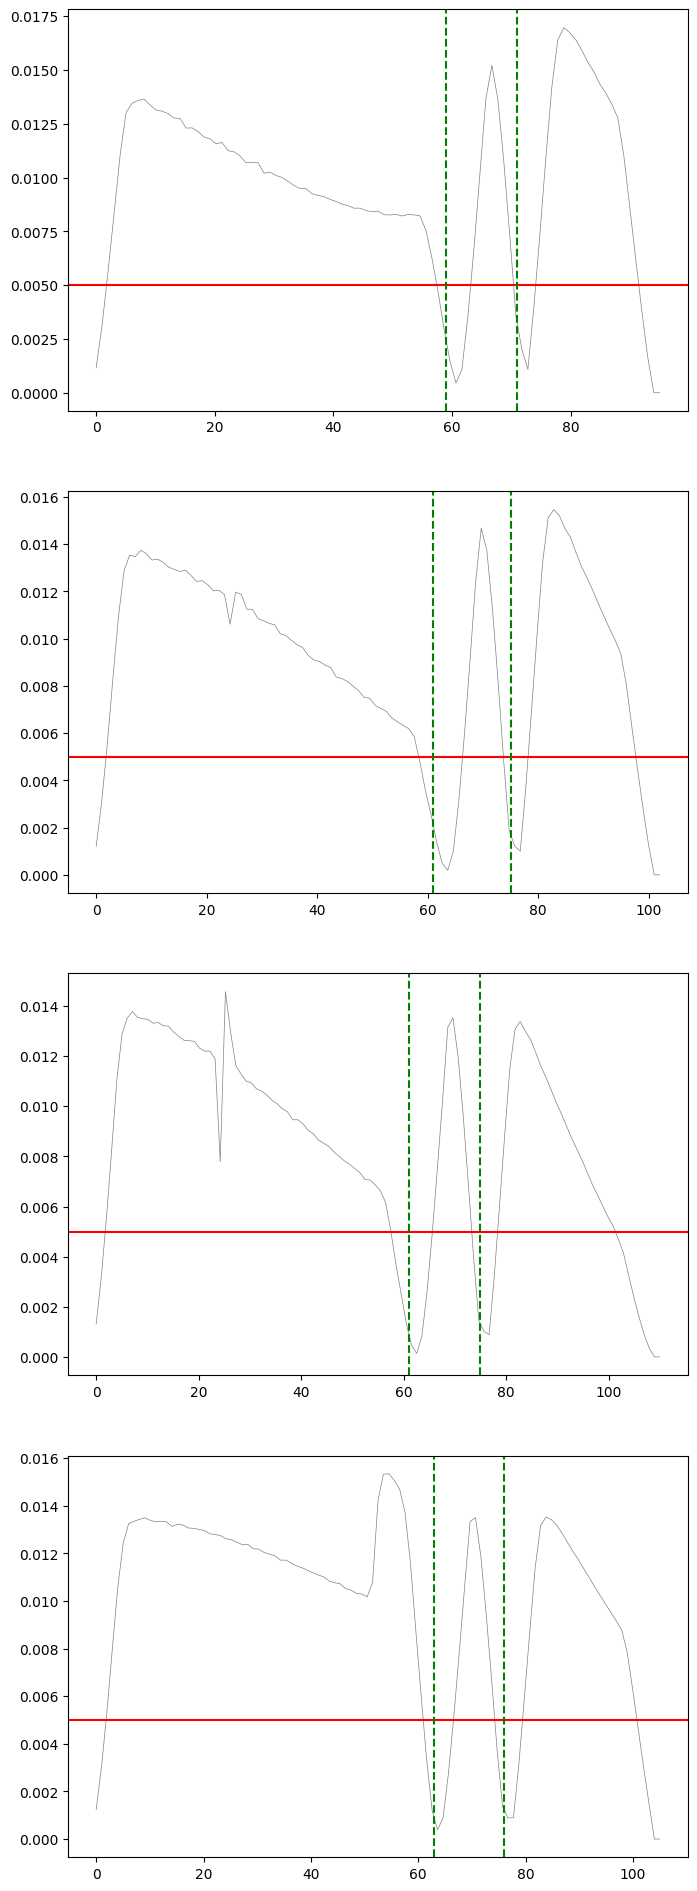

2025-07-30 11:26:00.832 | INFO     |  Creating segement of demos.
2025-07-30 11:26:00.835 | INFO     |  Subsampling to length 61 using strategy mean-length.
2025-07-30 11:26:00.836 | INFO     |  Creating segement of demos.
2025-07-30 11:26:00.838 | INFO     |  Subsampling to length 13 using strategy mean-length.
2025-07-30 11:26:00.839 | INFO     |  Creating segement of demos.
2025-07-30 11:26:00.841 | INFO     |  Subsampling to length 28 using strategy mean-length.
2025-07-30 11:26:00.842 | INFO     |  ... created 3 segments
2025-07-30 11:26:00.842 | INFO     |    Fitting candidate frame 1/2
2025-07-30 11:26:00.842 | INFO     |    Creating partial frame view of demos.
2025-07-30 11:26:00.847 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-07-30 11:26:00.847 | INFO     |    Changing number of components to 11
2025-07-30 11:26:00.848 | INFO     |    Model init ...


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2025-07-30 11:26:01.332 | INFO     |    Fitting candidate frame 2/2
2025-07-30 11:26:01.332 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2025-07-30 11:26:01.820 | INFO     |  ee_init    score (rel):     -1 (1.000)
2025-07-30 11:26:01.820 | INFO     |  obj000     score (rel):     -1 (0.998)
2025-07-30 11:26:01.821 | INFO     |  Creating partial frame view of demos.
2025-07-30 11:26:01.823 | INFO     |    Fitting candidate frame 1/2
2025-07-30 11:26:01.824 | INFO     |    Creating partial frame view of demos.
2025-07-30 11:26:01.832 | INFO     |    Changing number of components to 5


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-30 11:26:01.924 | INFO     |    Fitting candidate frame 2/2
2025-07-30 11:26:01.925 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-30 11:26:02.025 | INFO     |  ee_init    score (rel):     -0 (0.003)
2025-07-30 11:26:02.026 | INFO     |  obj000     score (rel):     -1 (1.000)
2025-07-30 11:26:02.026 | INFO     |  Creating partial frame view of demos.
2025-07-30 11:26:02.028 | INFO     |    Fitting candidate frame 1/2
2025-07-30 11:26:02.028 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-30 11:26:02.193 | INFO     |    Fitting candidate frame 2/2
2025-07-30 11:26:02.193 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-30 11:26:02.353 | INFO     |  Creating partial frame view of demos.
2025-07-30 11:26:02.355 | INFO     |  Segmented trajs into 3 segments
2025-07-30 11:26:02.371 | INFO     |  Frame score (abs):
            ee_init    obj000
Segment 0 -0.998883 -0.997091
Segment 1 -0.002569 -0.998874
Segment 2 -0.002722 -0.998951
2025-07-30 11:26:02.373 | INFO     |  Frame score (rel):
            ee_init    obj000
Segment 0  1.000000  0.998206
Segment 1  0.002572  1.000000
Segment 2  0.002725  1.000000


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-30 11:26:02.405 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

((array([[1.70e+19, 1.68e+19, 4.92e+18, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [5.48e+16, 2.38e+17, 5.90e+17, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.77e+06, 3.75e+07, 6.95e+08, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.04e-04, 1.39e-07, 6.65e-10],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 5.14e+15, 6.24e+14, 7.88e+13],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.93e+18, 5.18e+18, 2.83e+18]]),
  array([[8.37e+11, 9.08e+11, 3.65e+11, 6.17e+10, 3.87e+09, 6.41e+07,
          1.38e+05, 6.36e+02, 2.49e-02, 2.84e-08, 3.63e-15, 2.72e-22,
          4.72e-29, 6.26e+11, 9.12e+11, 3.69e+11, 6.17e+10, 4.26e+09,
          1.11e+08, 8.35e+05, 4.40e+01, 2.71e-04, 1.38e-10, 2.52e-17,
          6.10e-24, 5.34e-30, 9.12e+11, 8.66e+11, 3.56e+11, 6.08e+10,
          4.02e+09, 8.51e+07, 3.89e+05, 2.79e+00, 1.02e-05, 6.68e-12,
          2.57e-18, 1.55e-24, 2.87e-30, 8.30e+11, 8.53e+11, 3.58e+11,
          5.81e+10, 2.98e+09, 3.15e+07

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-07-30 11:26:03.958 | INFO     |  Did not specify time_based, deciding automatically.
2025-07-30 11:26:04.120 | WARNING  |  Skippig NaN Gaussians.


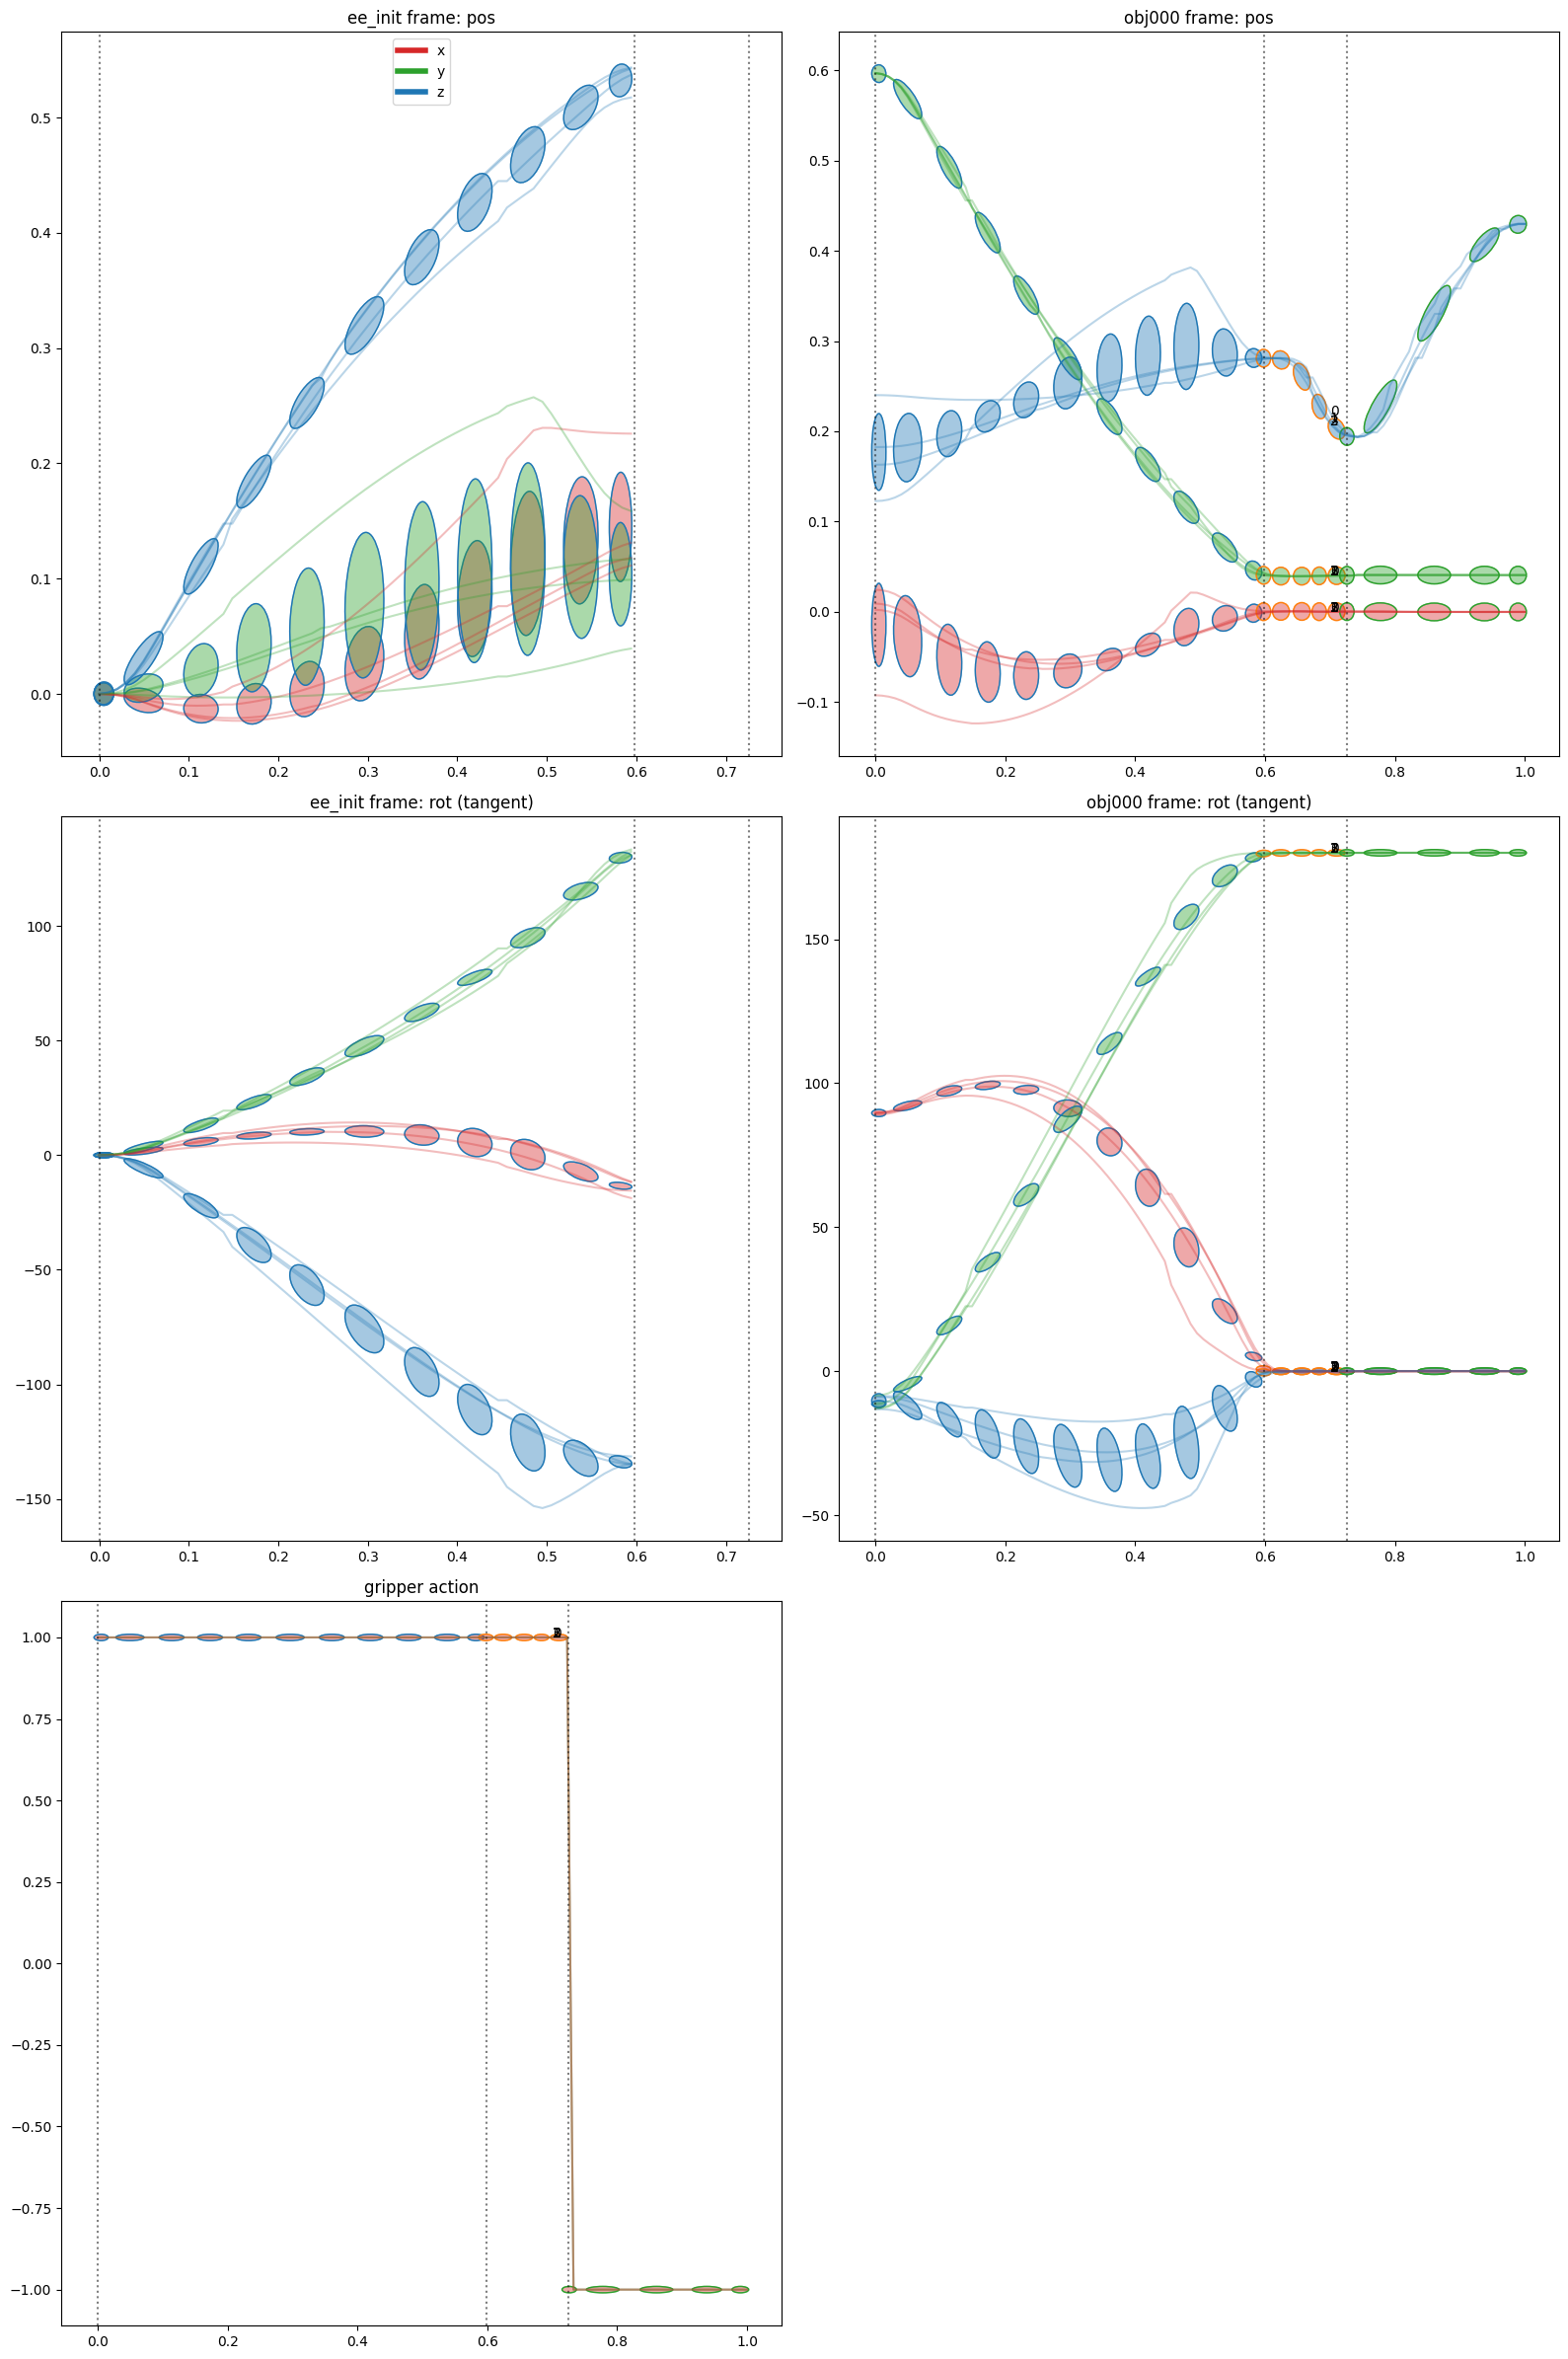

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-07-30 11:26:11.352 | INFO     |  Fitting AutoTPGMM
2025-07-30 11:26:11.352 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-30 11:26:11.363 | INFO     |  HMM EM ...
2025-07-30 11:26:11.378 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-30 11:26:11.541 | INFO     |  HMM init priors not defined, initializing to uniform
2025-07-30 11:26:13.168 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[9.97e-01, 9.86e-01, 8.93e-01, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [3.22e-03, 1.39e-02, 1.07e-01, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.04e-13, 2.20e-12, 1.26e-10, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.05e-22, 2.68e-26, 2.35e-28],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.65e-03, 1.20e-04, 2.78e-05],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 9.97e-01, 1.00e+00, 1.00e+00]]),
  array([[9.65e-01, 7.88e-01, 3.49e-01, 5.96e-02, 4.56e-03, 9.48e-05,
          1.92e-07, 1.22e-09, 4.82e-14, 3.73e-20, 5.59e-27, 3.22e-34,
          7.61e-41, 9.75e-01, 8.03e-01, 3.51e-01, 6.04e-02, 5.19e-03,
          1.81e-04, 1.47e-06, 7.46e-11, 3.43e-16, 1.65e-22, 3.28e-29,
          6.99e-36, 9.00e-42, 9.51e-01, 7.71e-01, 3.43e-01, 5.89e-02,
          4.73e-03, 1.27e-04, 5.64e-07, 5.13e-12, 1.24e-17, 8.71e-24,
          3.36e-30, 1.84e-36, 4.95e-42, 9.43e-01, 7.69e-01, 3.44e-01,
          5.66e-02, 3.84e-03, 5.06e-05

2025-07-30 11:26:16.754 | INFO     |  Did not specify time_based, deciding automatically.


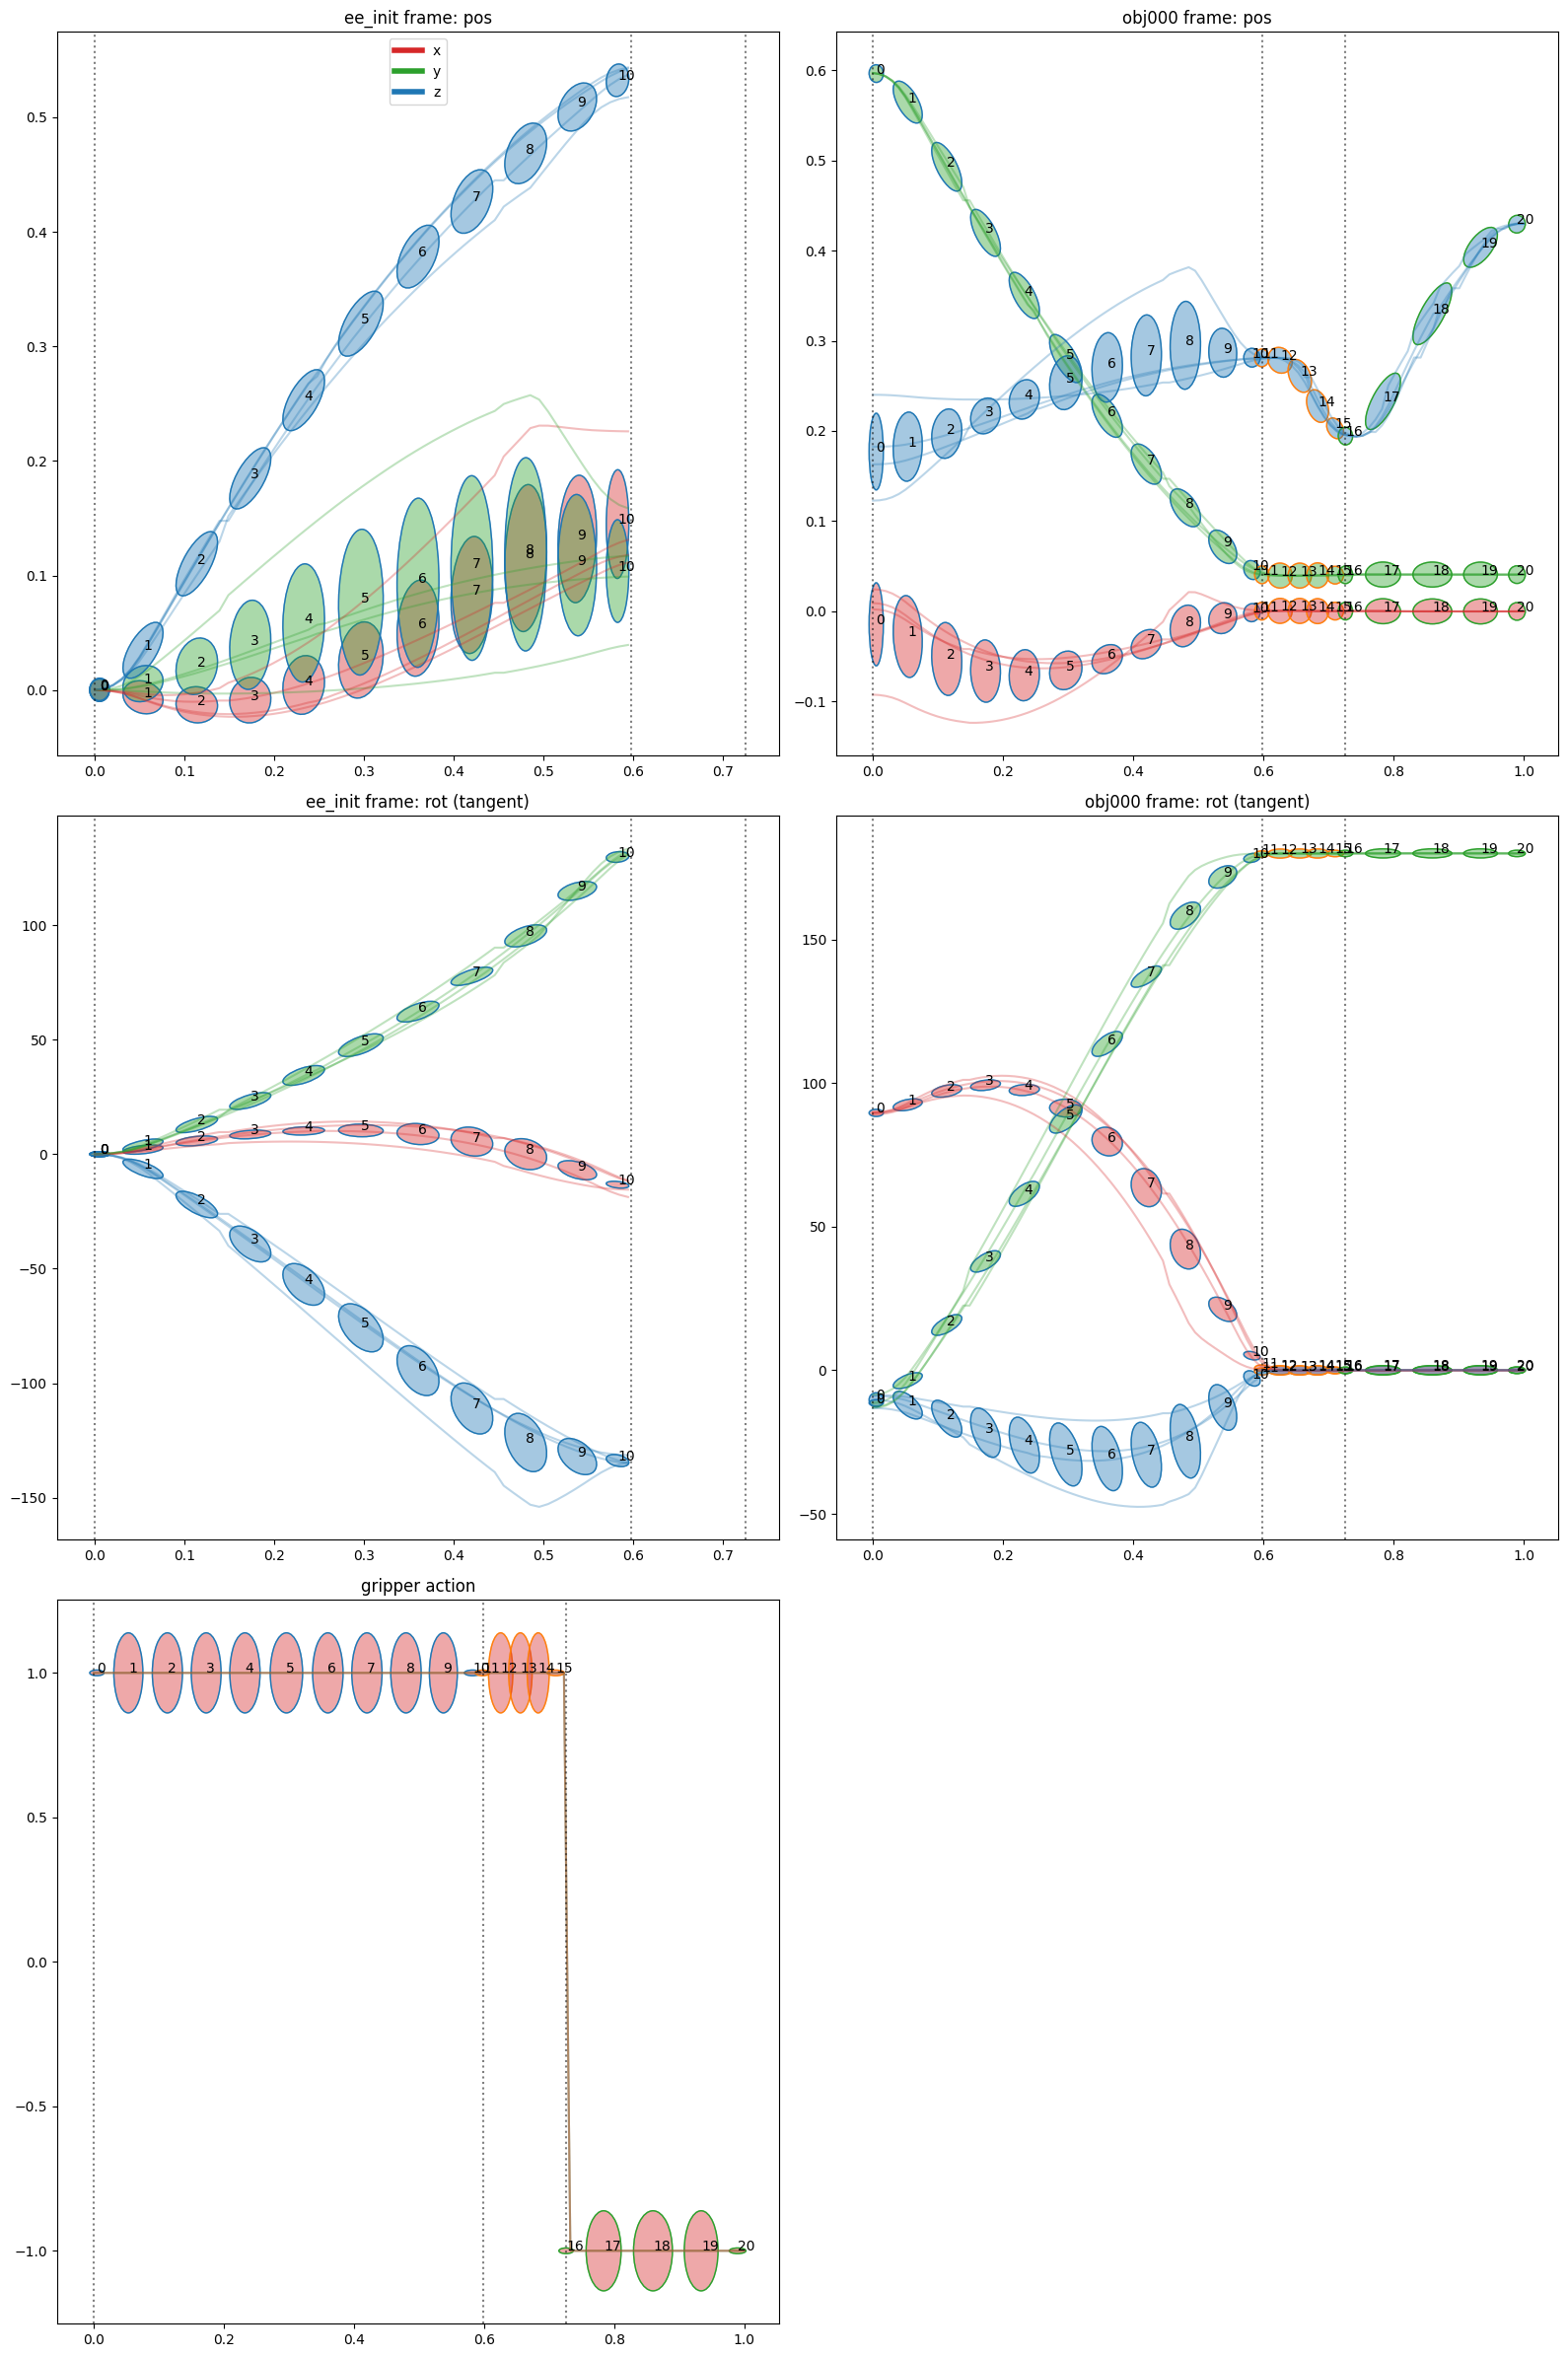

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

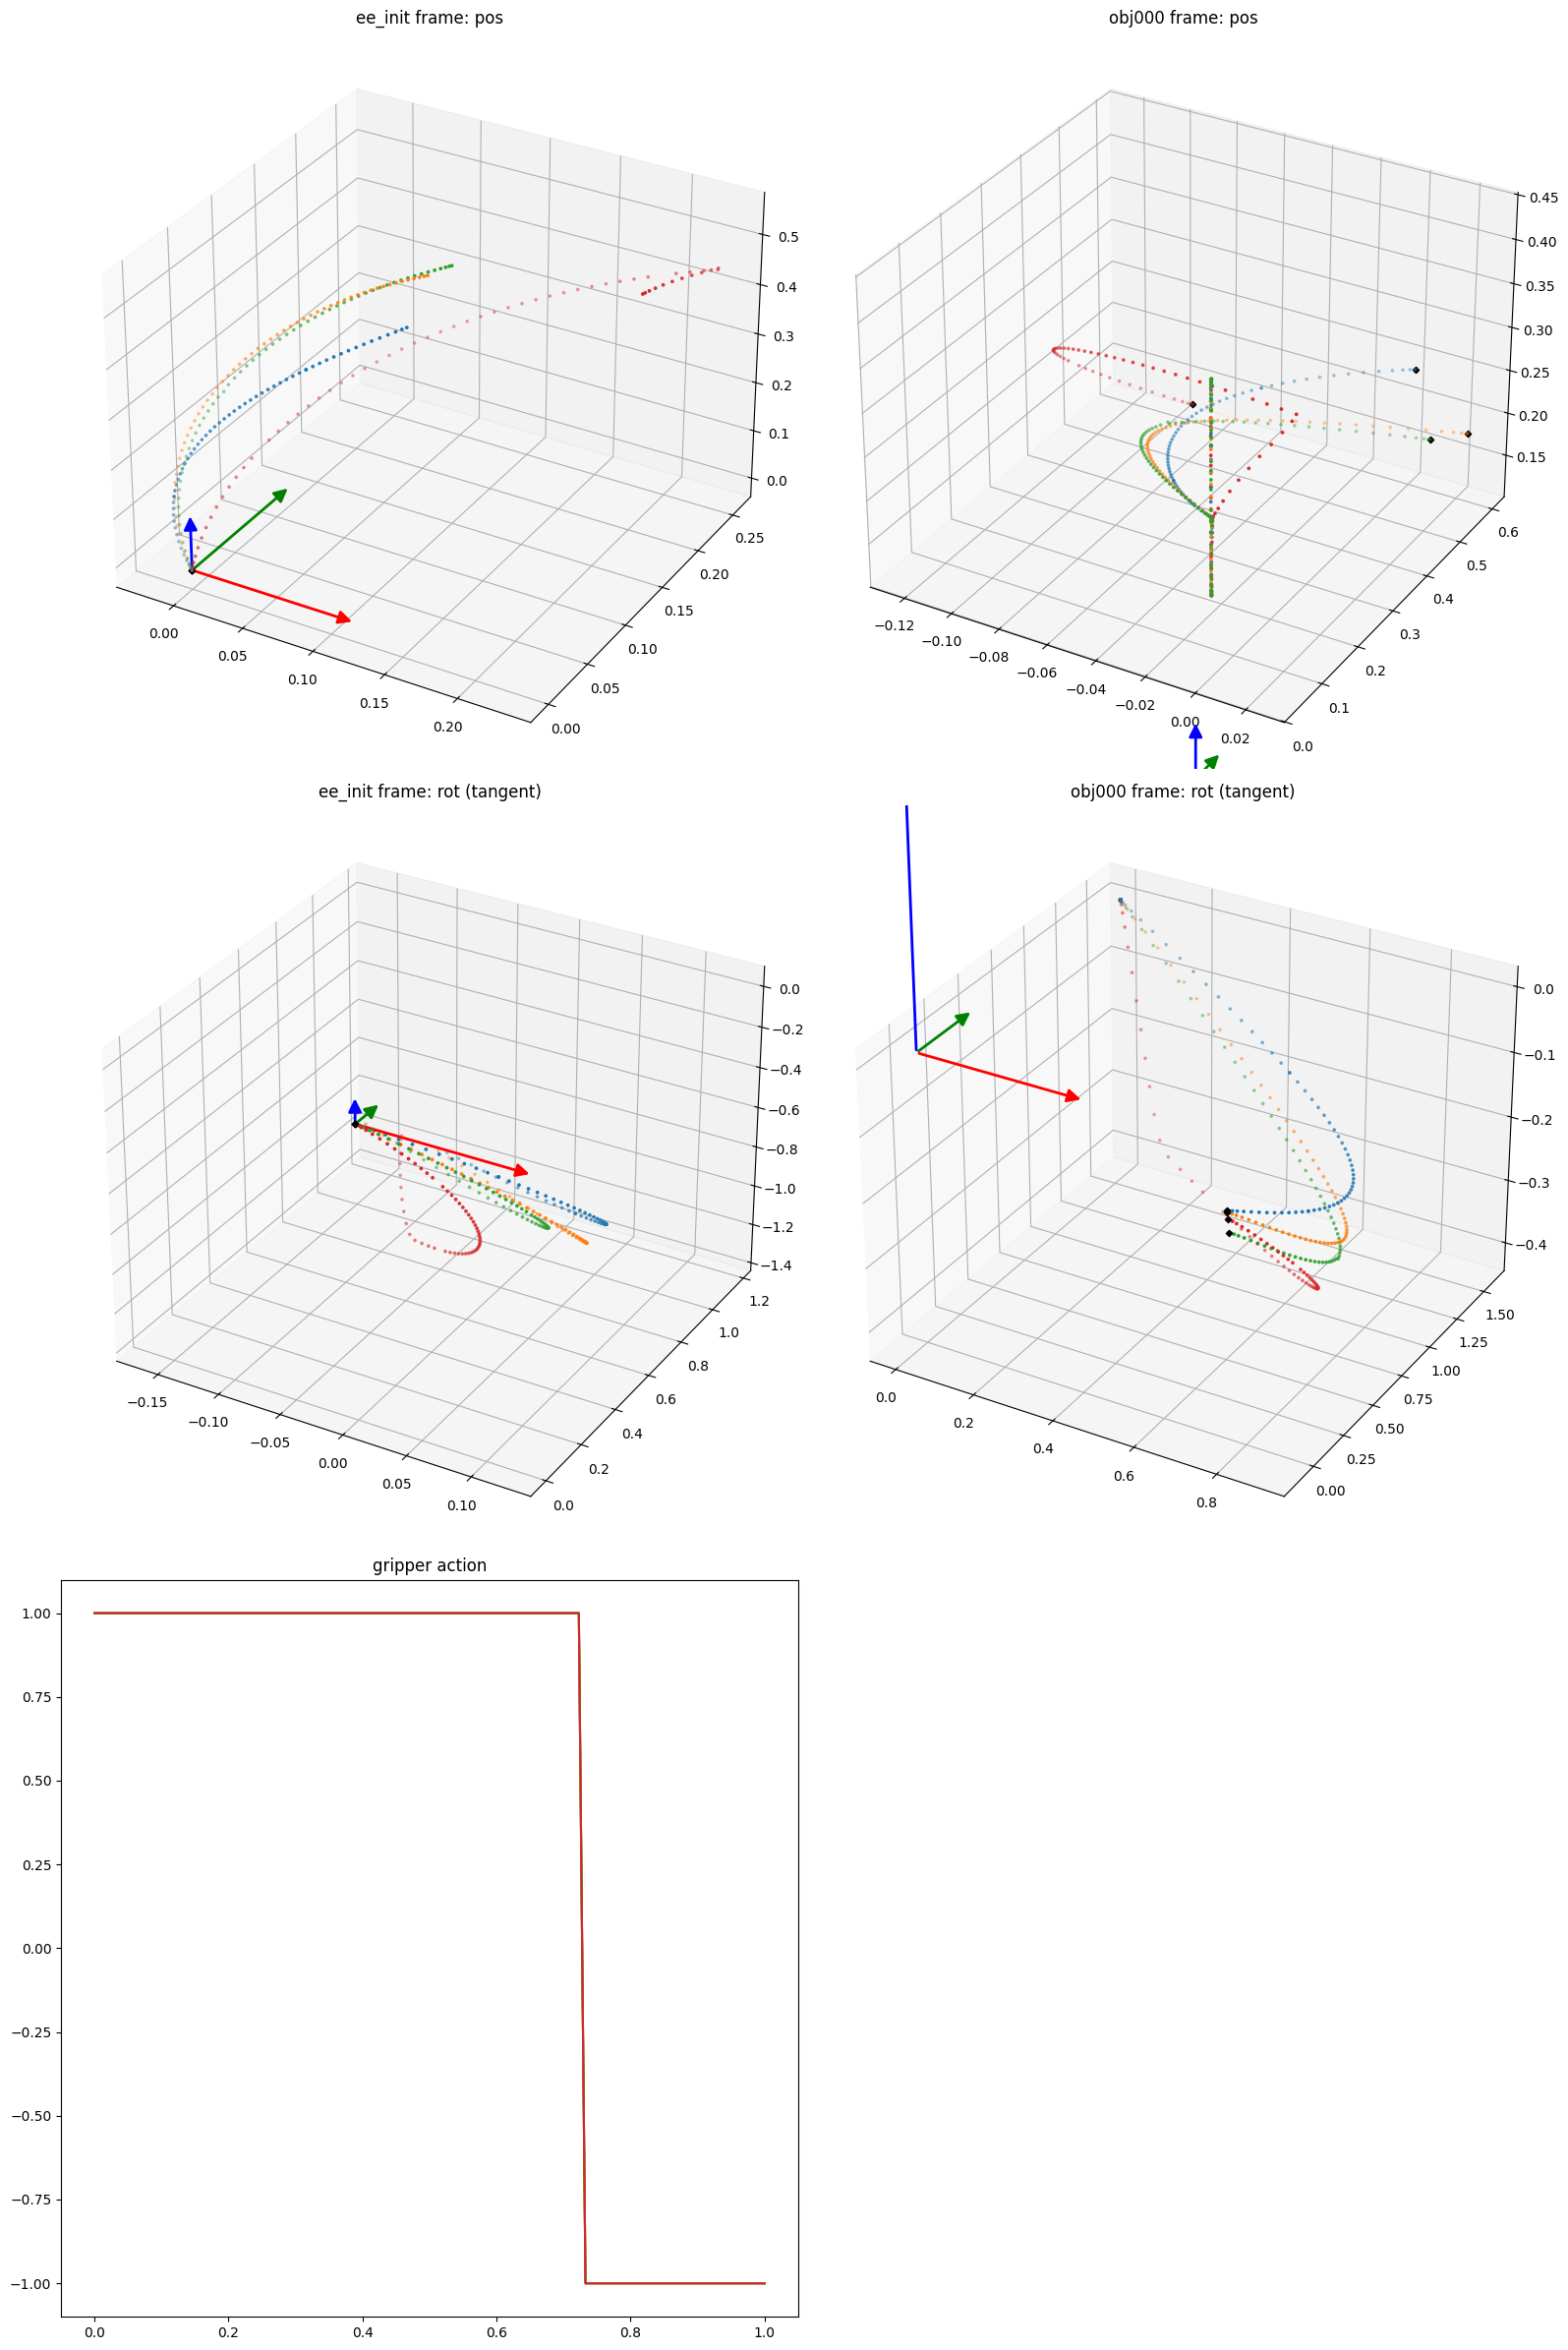

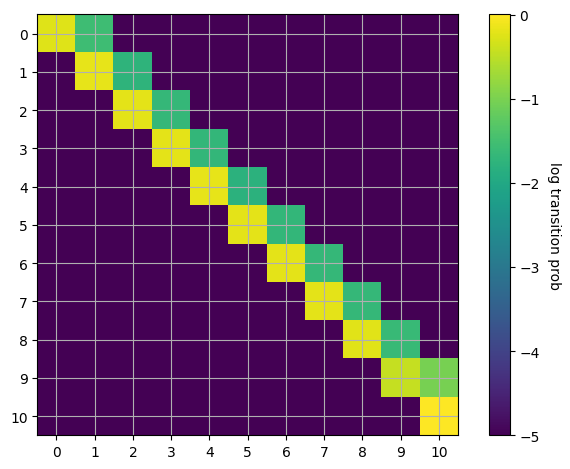

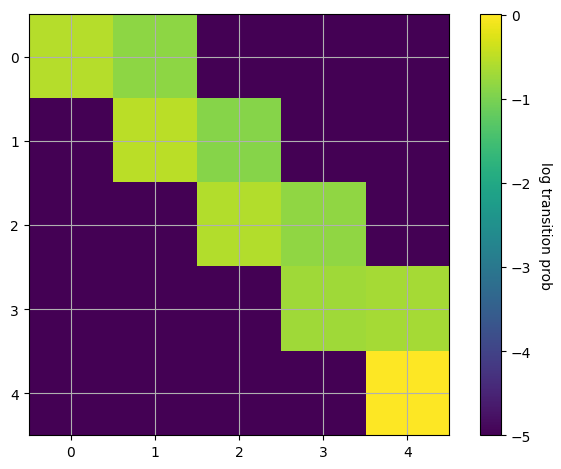

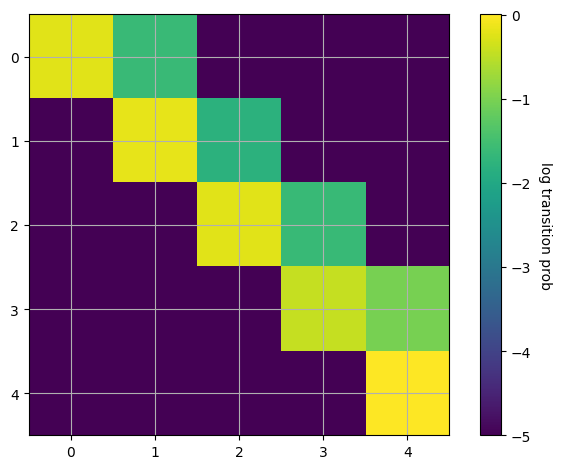

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [20]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

In [16]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-07-30 11:27:05.306 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-07-30 11:27:05.368 | INFO     |  Caculated segment transition probabilities: (array([[0.85]]), array([[0.67]]))
2025-07-30 11:27:05.369 | INFO     |  Creating partial frame view of demos.
2025-07-30 11:27:05.373 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-30 11:27:05.844 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-30 11:27:05.945 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-30 11:27:06.057 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

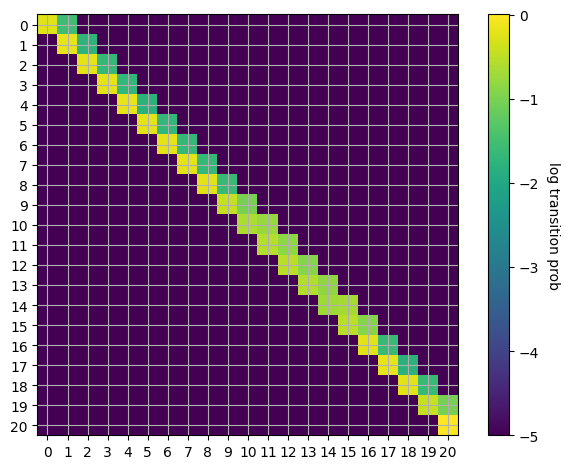

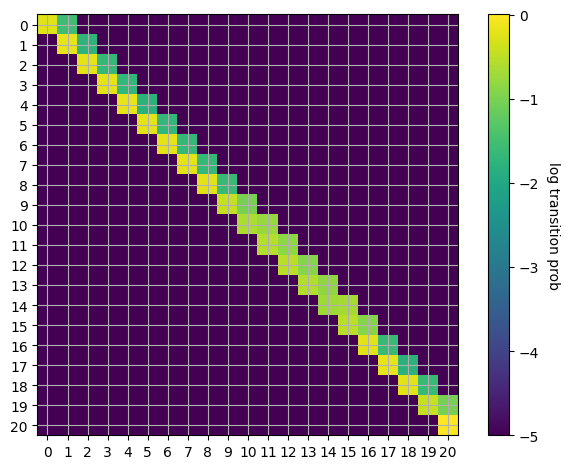

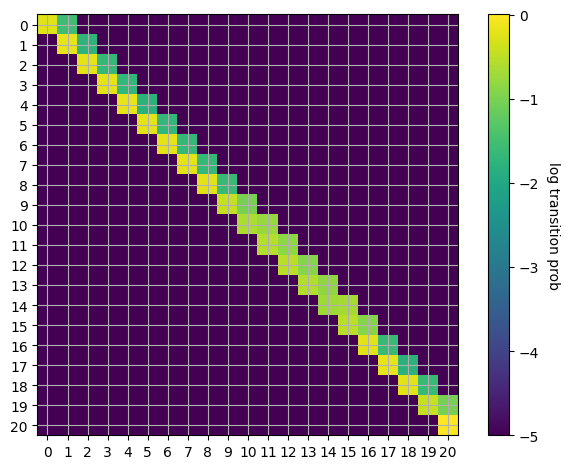

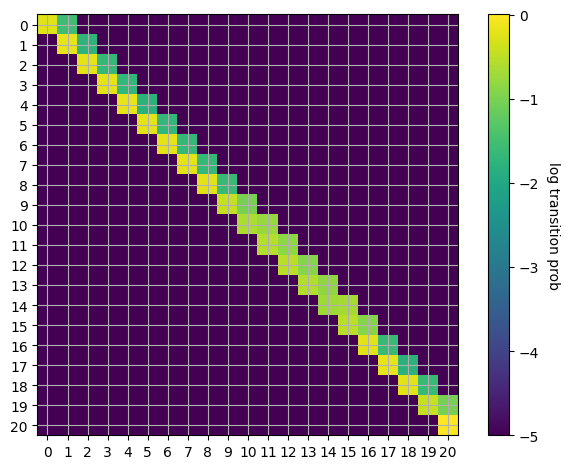

In [17]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-07-30 11:27:52.407 | INFO     |  Taking frame origins from demos.


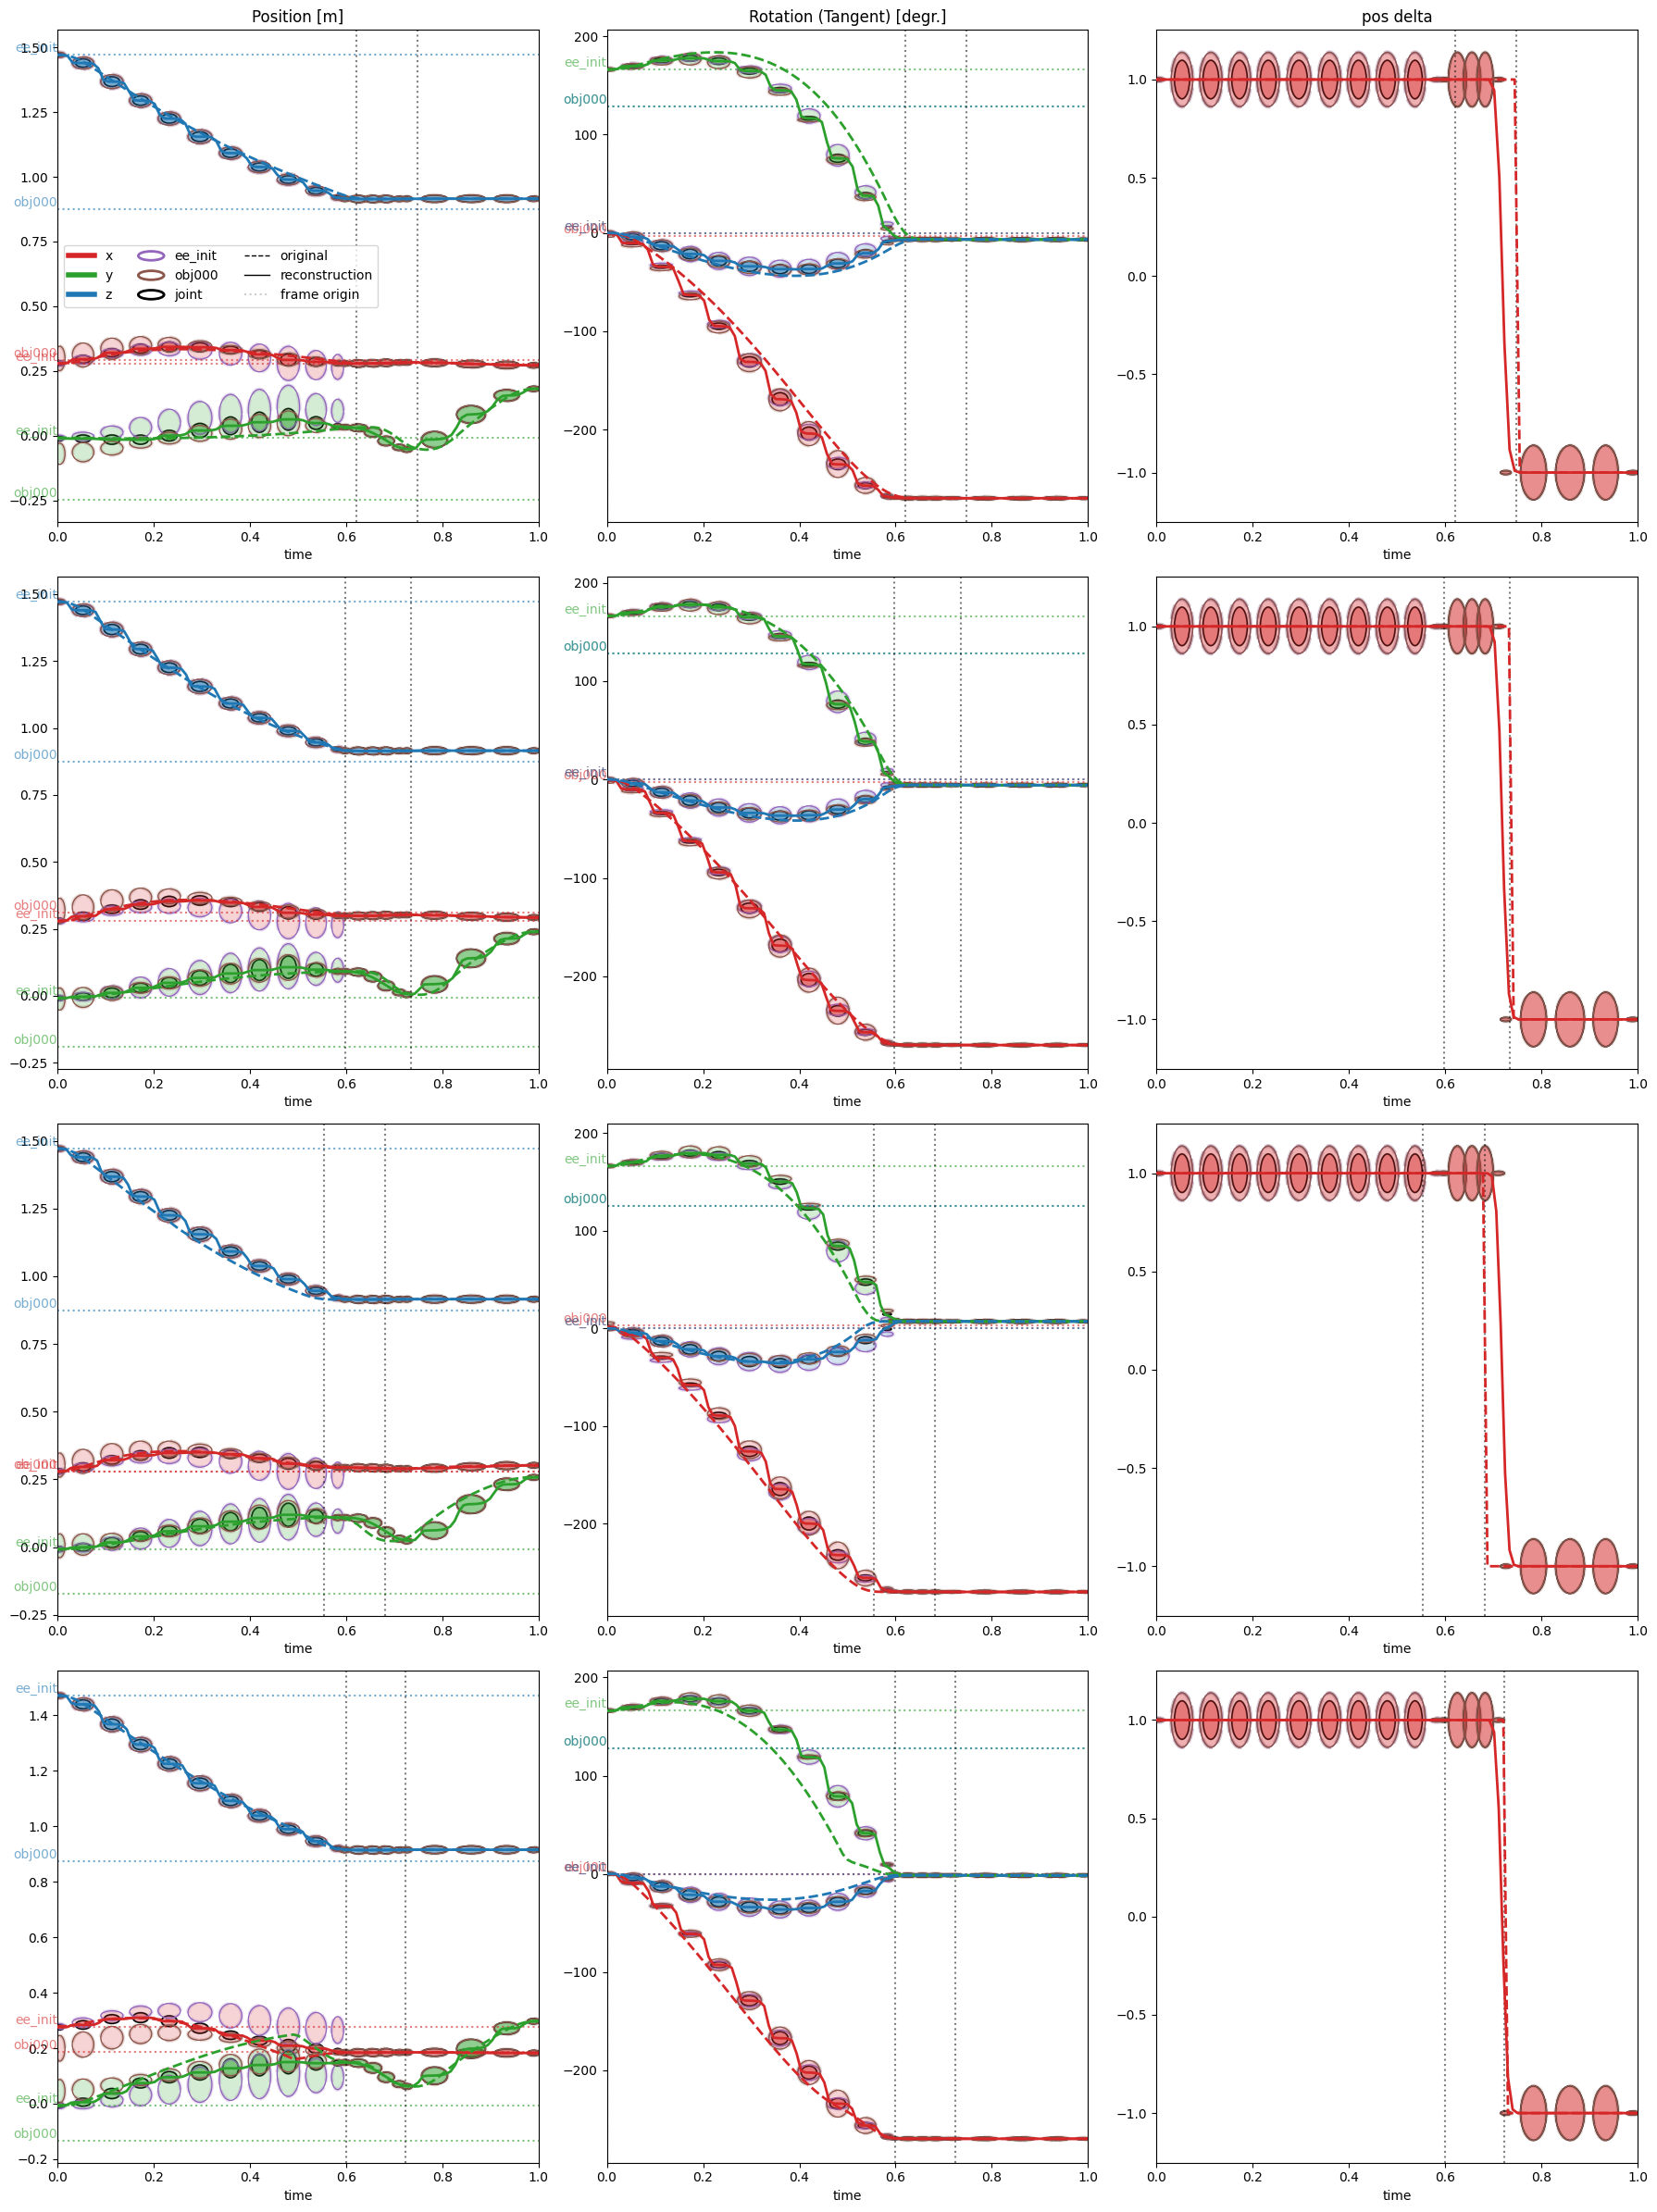

In [18]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [19]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


2025-07-30 11:28:44.668 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.
